<a href="https://colab.research.google.com/github/ryzwann/aaa/blob/main/EfficientNetB2fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import timm

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
from PIL import Image
from torchvision.datasets import ImageFolder

# Folder input dan output
input_dir = "/content/drive/MyDrive/penyakit kulit jamur"
output_dir = "/content/drive/MyDrive/dataset_augmented"
os.makedirs(output_dir, exist_ok=True)

# Transformasi augmentasi (tanpa ToTensor!)
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])

# Muat dataset asli tanpa transform
dataset = ImageFolder(input_dir)

n_augments = 3  # Simpan 3 augmentasi per gambar
print("Mulai augmentasi dan menyimpan ke folder baru...")
for idx, (img, label) in enumerate(dataset):
    class_name = dataset.classes[label]
    class_path = os.path.join(output_dir, class_name)
    os.makedirs(class_path, exist_ok=True)

    for i in range(n_augments):
        aug_img = augment_transform(img)
        aug_img.save(os.path.join(class_path, f"{idx}_{i}.jpg"))

print("✅ Augmentasi selesai.")


Mulai augmentasi dan menyimpan ke folder baru...
✅ Augmentasi selesai.


In [ ]:
data_dir = "/content/drive/MyDrive/dataset_augmented"  # hasil augmentasi

# Cek isi folder
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"Ada {len(filenames)} file di direktori: {dirpath}")

walk_through_dir(data_dir)

# Transformasi akhir (untuk training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


Ada 0 file di direktori: /content/drive/MyDrive/dataset_augmented
Ada 495 file di direktori: /content/drive/MyDrive/dataset_augmented/Kurap (Ringworm)
Ada 495 file di direktori: /content/drive/MyDrive/dataset_augmented/Kutu Air (Athlete Foot)
Ada 408 file di direktori: /content/drive/MyDrive/dataset_augmented/Panu (Tinea Versicolor)
Ada 357 file di direktori: /content/drive/MyDrive/dataset_augmented/Panu Hitam (Tinea Nigra)


In [ ]:
# Load dataset dari folder augmentasi
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = full_dataset.classes
print("Classes:", class_names)

# Split dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


Classes: ['Kurap (Ringworm)', 'Kutu Air (Athlete Foot)', 'Panu (Tinea Versicolor)', 'Panu Hitam (Tinea Nigra)']


In [ ]:
import os
import shutil
import random
from tqdm import tqdm

# Path asal dataset yang belum di-split
original_dir = "/content/drive/MyDrive/dataset_augmented"

# Path tujuan setelah split
base_split_dir = "/content/drive/MyDrive/dataset_augmented_split"
train_dir = os.path.join(base_split_dir, "train")
val_dir = os.path.join(base_split_dir, "val")
test_dir = os.path.join(base_split_dir, "test")

# Buat folder baru jika belum ada
for path in [train_dir, val_dir, test_dir]:
    os.makedirs(path, exist_ok=True)

# Set rasio split
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Untuk setiap kelas
for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Dapatkan semua file gambar
    files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(files)

    # Hitung jumlah data
    total = len(files)
    train_split = int(train_ratio * total)
    val_split = int(val_ratio * total)

    train_files = files[:train_split]
    val_files = files[train_split:train_split + val_split]
    test_files = files[train_split + val_split:]

    # Salin file ke direktori target masing-masing
    for subset, subset_files in zip(
        [train_dir, val_dir, test_dir],
        [train_files, val_files, test_files]
    ):
        subset_class_dir = os.path.join(subset, class_name)
        os.makedirs(subset_class_dir, exist_ok=True)

        for file_name in tqdm(subset_files, desc=f"Copying {class_name} to {os.path.basename(subset)}"):
            src = os.path.join(class_path, file_name)
            dst = os.path.join(subset_class_dir, file_name)
            shutil.copyfile(src, dst)

print("Selesai membagi dataset ke train / val / test.")


Copying Panu Hitam (Tinea Nigra) to test: 100%|██████████| 55/55 [00:00<00:00, 135.86it/s]

Selesai membagi dataset ke train / val / test.


In [ ]:
import os

# Path ke direktori hasil split
split_dir = "/content/drive/MyDrive/dataset_augmented_split"

def count_images_in_split(split_dir):
    sets = ['train', 'val', 'test']
    total_all = 0

    for s in sets:
        folder = os.path.join(split_dir, s)
        count = 0
        for class_dir in os.listdir(folder):
            class_path = os.path.join(folder, class_dir)
            if os.path.isdir(class_path):
                count += len([
                    f for f in os.listdir(class_path)
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
                ])
        print(f"Jumlah data {s}: {count}")
        total_all += count

    print(f"Total jumlah data: {total_all}")

# Jalankan fungsi
count_images_in_split(split_dir)


Jumlah data train: 1226
Jumlah data val: 262
Jumlah data test: 267
Total jumlah data: 1755


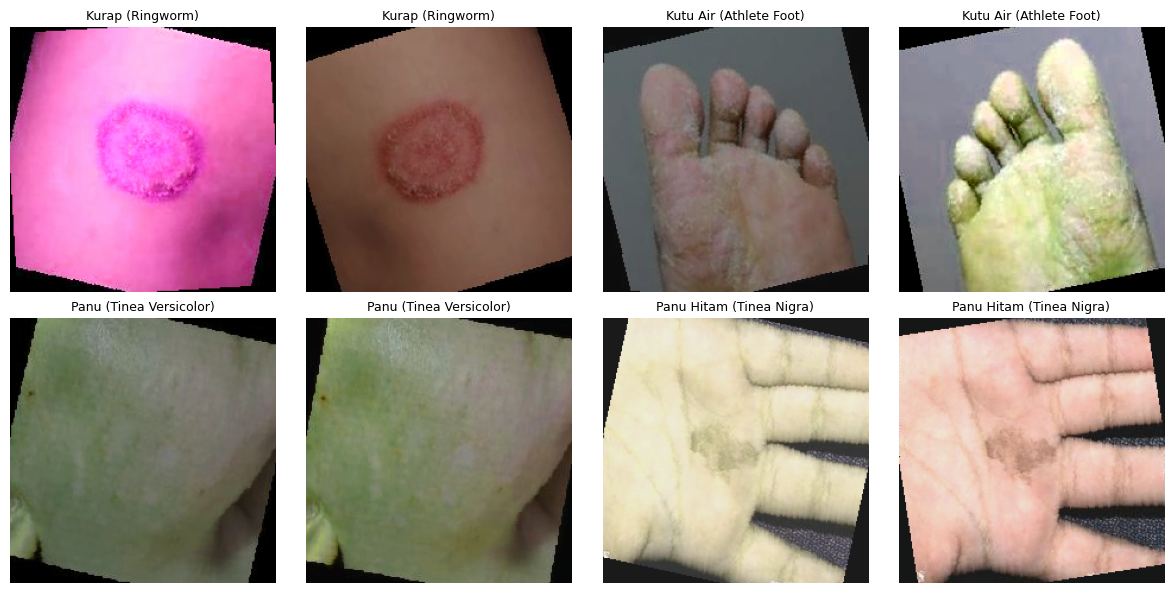

In [ ]:
def show_balanced_samples(dataset, class_names, samples_per_class=2):
    class_to_imgs = {cls: [] for cls in range(len(class_names))}

    for idx, (img, label) in enumerate(dataset):
        if len(class_to_imgs[label]) < samples_per_class:
            class_to_imgs[label].append((img, label))
        if all(len(imgs) >= samples_per_class for imgs in class_to_imgs.values()):
            break

    plt.figure(figsize=(12, 6))
    i = 1
    for cls, imgs in class_to_imgs.items():
        for img, label in imgs:
            img = img.permute(1, 2, 0).numpy()
            img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
            img = np.clip(img, 0, 1)

            plt.subplot(2, 4, i)
            plt.imshow(img)
            plt.title(class_names[label], fontsize=9)
            plt.axis('off')
            i += 1

    plt.tight_layout()
    plt.show()

# Tampilkan gambar
show_balanced_samples(full_dataset, class_names, samples_per_class=2)


In [ ]:
import timm

paths, labels = [], []
for path, label in full_dataset.imgs:
    paths.append(path)
    labels.append(full_dataset.classes[label])
df = pd.DataFrame({'image_path': paths, 'label': labels})
df.head()

# Memeriksa format gambar yang dihasilkan oleh DataLoader
images, labels = next(iter(train_loader))
print(images.shape)  # Pastikan gambar dalam format tensor



torch.Size([32, 3, 224, 224])


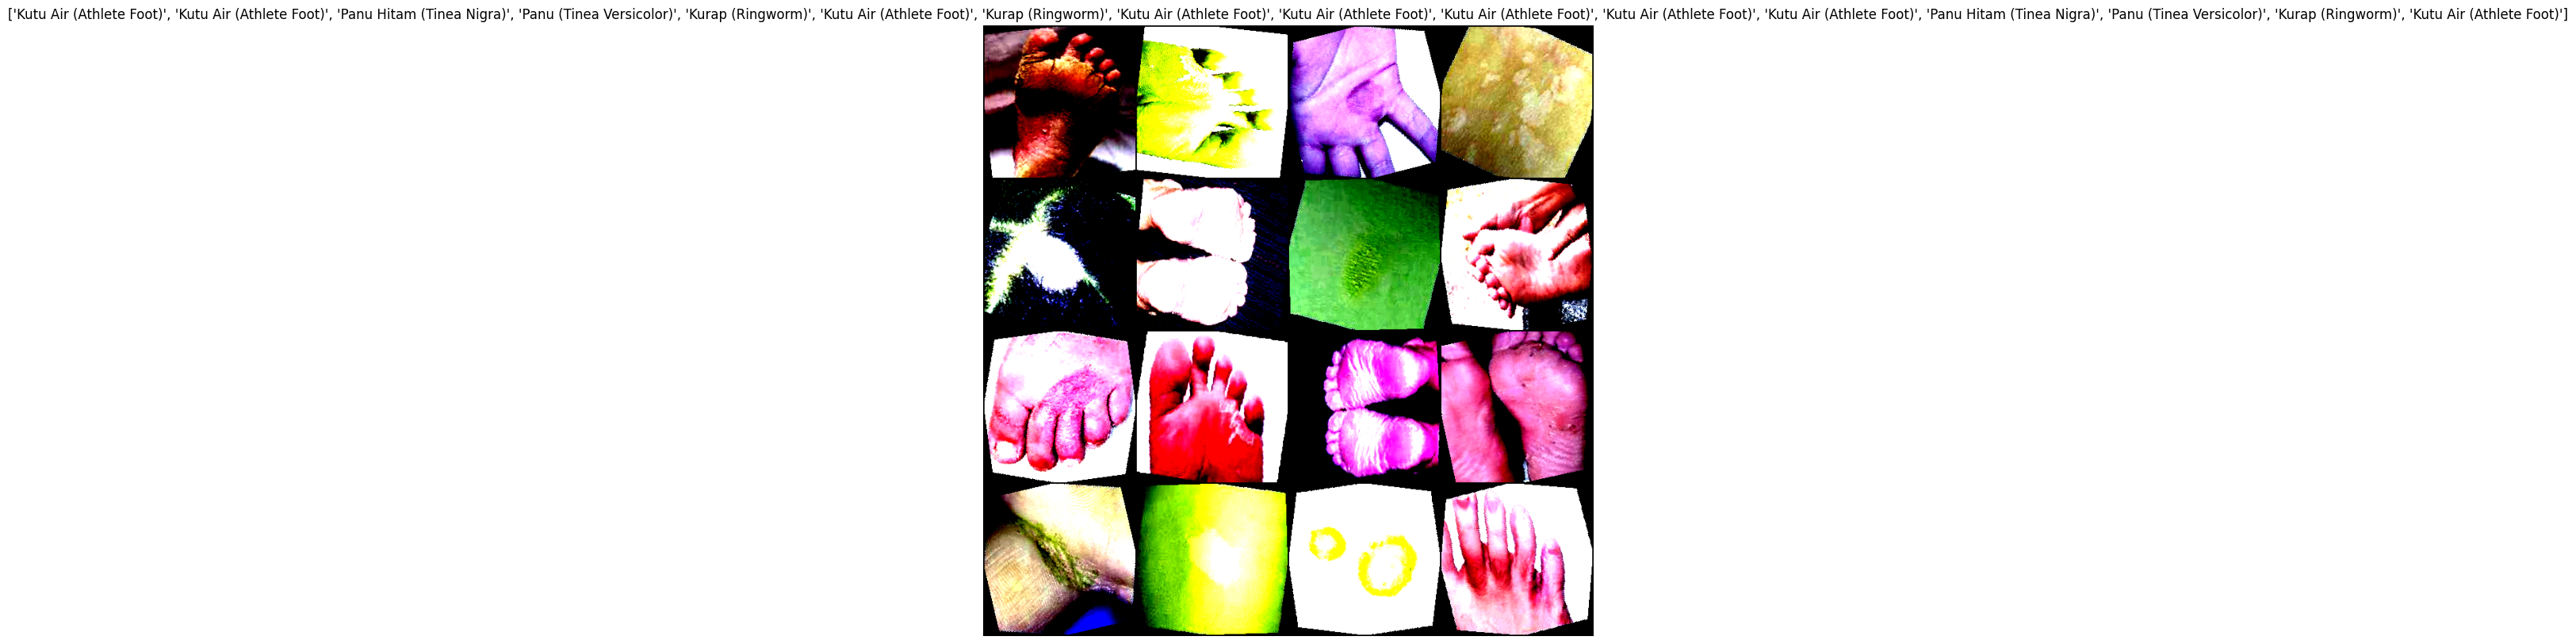

In [ ]:
import timm
import os
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_batch(loader, class_names):
    images, labels = next(iter(loader))

    # Pastikan gambar sudah dalam bentuk tensor
    images = images[:16]
    labels = labels[:16]

    # Buat grid gambar
    grid = make_grid(images, nrow=4)

    # Menampilkan gambar
    plt.figure(figsize=(10,10))
    plt.imshow(grid.permute(1, 2, 0).cpu())  # Convert dari tensor [C, H, W] ke [H, W, C] dan pindah ke CPU
    plt.title([class_names[i] for i in labels])
    plt.axis('off')
    plt.show()

# Contoh pemanggilan fungsi
# Gantilah 'class_names' dengan daftar nama kelas yang sesuai
show_batch(train_loader, class_names)


In [ ]:
import timm
import torch
import torch.nn as nn
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inisialisasi model EfficientNet-B2
model = timm.create_model('efficientnet_b2', pretrained=True)

# Ambil fitur dari classifier EfficientNet-B2
num_features = model.classifier.in_features

# Ganti classifier akhir untuk 4 kelas (jumlah kelas kamu)
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, 4)  # 4 kelas
)

# Pindahkan model ke device (GPU atau CPU)
model = model.to(device)

# Fungsi akurasi dan evaluasi
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

def evaluate(model, loader):
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            total_correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return total_correct / total

# Simpan model ke Google Drive
os.makedirs('/content/drive/MyDrive/Models', exist_ok=True)
torch.save(model.state_dict(), '/content/drive/MyDrive/Models/model_efficientnetb2_jamur.pth')
print("Model berhasil disimpan di Google Drive.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

Model berhasil disimpan di Google Drive.


In [ ]:
import timm
import torch

# Load state_dict dari model EfficientNet-B2
state = torch.load("/content/drive/MyDrive/Models/model_efficientnetb2_jamur.pth", map_location='cpu')

# Tampilkan semua key yang tersedia di state_dict
print("Daftar key dalam state_dict:")
for key in state.keys():
    print(key)

# Tampilkan shape dari layer classifier terakhir
print("\nShape weight layer classifier terakhir:")
print(state['classifier.1.weight'].shape)


Daftar key dalam state_dict:
conv_stem.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
blocks.0.0.conv_dw.weight
blocks.0.0.bn1.weight
blocks.0.0.bn1.bias
blocks.0.0.bn1.running_mean
blocks.0.0.bn1.running_var
blocks.0.0.bn1.num_batches_tracked
blocks.0.0.se.conv_reduce.weight
blocks.0.0.se.conv_reduce.bias
blocks.0.0.se.conv_expand.weight
blocks.0.0.se.conv_expand.bias
blocks.0.0.conv_pw.weight
blocks.0.0.bn2.weight
blocks.0.0.bn2.bias
blocks.0.0.bn2.running_mean
blocks.0.0.bn2.running_var
blocks.0.0.bn2.num_batches_tracked
blocks.0.1.conv_dw.weight
blocks.0.1.bn1.weight
blocks.0.1.bn1.bias
blocks.0.1.bn1.running_mean
blocks.0.1.bn1.running_var
blocks.0.1.bn1.num_batches_tracked
blocks.0.1.se.conv_reduce.weight
blocks.0.1.se.conv_reduce.bias
blocks.0.1.se.conv_expand.weight
blocks.0.1.se.conv_expand.bias
blocks.0.1.conv_pw.weight
blocks.0.1.bn2.weight
blocks.0.1.bn2.bias
blocks.0.1.bn2.running_mean
blocks.0.1.bn2.running_var
blocks.0.1.bn2.num_batch

In [ ]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim

# Load EfficientNet-B2 dari timm
model = timm.create_model('efficientnet_b2', pretrained=True)

# Freeze semua parameter agar tidak di-train (jika hanya fine-tune classifier)
for param in model.parameters():
    param.requires_grad = False

# Ambil jumlah fitur dari classifier asli EfficientNet-B2
num_features = model.classifier.in_features

# Ganti layer classifier akhir untuk jumlah kelas (misalnya len(class_names) = 4)
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, len(class_names))  # class_names sudah terdefinisi sebelumnya
)

# Pindahkan model ke device
model = model.to(device)


In [ ]:
import time
start_time = time.time()


In [ ]:
import timm
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

epochs = 50

for epoch in range(epochs):
    # === TRAINING ===
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(outputs.argmax(1) == labels)

    train_loss = running_loss / train_size
    train_acc = running_corrects.double() / train_size

    # === VALIDATION ===
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item() * val_inputs.size(0)
            val_running_corrects += torch.sum(val_outputs.argmax(1) == val_labels)

    val_loss = val_running_loss / val_size
    val_acc = val_running_corrects.double() / val_size

    # === Simpan history ===
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    # === Print format seperti yang kamu minta ===
    print(f"Epoch {epoch+1:>2}/{epochs} | "
      f"Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}% | "
      f"Val Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%")



Epoch  1/50 | Train Loss: 1.0864, Acc: 59.77% | Val Loss: 0.8249, Acc: 79.09%
Epoch  2/50 | Train Loss: 0.7182, Acc: 79.72% | Val Loss: 0.6053, Acc: 86.69%
Epoch  3/50 | Train Loss: 0.5643, Acc: 84.53% | Val Loss: 0.5261, Acc: 88.21%
Epoch  4/50 | Train Loss: 0.4825, Acc: 87.13% | Val Loss: 0.4427, Acc: 90.11%
Epoch  5/50 | Train Loss: 0.4324, Acc: 88.11% | Val Loss: 0.4340, Acc: 88.97%
Epoch  6/50 | Train Loss: 0.3970, Acc: 89.74% | Val Loss: 0.3638, Acc: 90.11%
Epoch  7/50 | Train Loss: 0.3777, Acc: 89.82% | Val Loss: 0.3728, Acc: 90.87%
Epoch  8/50 | Train Loss: 0.3777, Acc: 89.58% | Val Loss: 0.3177, Acc: 92.78%
Epoch  9/50 | Train Loss: 0.3432, Acc: 89.33% | Val Loss: 0.2986, Acc: 92.02%
Epoch 10/50 | Train Loss: 0.3061, Acc: 91.29% | Val Loss: 0.2749, Acc: 92.40%
Epoch 11/50 | Train Loss: 0.2904, Acc: 92.02% | Val Loss: 0.2813, Acc: 91.63%
Epoch 12/50 | Train Loss: 0.2913, Acc: 91.53% | Val Loss: 0.2725, Acc: 92.02%
Epoch 13/50 | Train Loss: 0.2825, Acc: 92.26% | Val Loss: 0.2737

In [ ]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")


Total training time: 938.40 seconds (15.64 minutes)


In [ ]:
import torch

def test_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")

# Panggil fungsi
test_accuracy(model, test_loader, device)


Test Accuracy: 94.32%


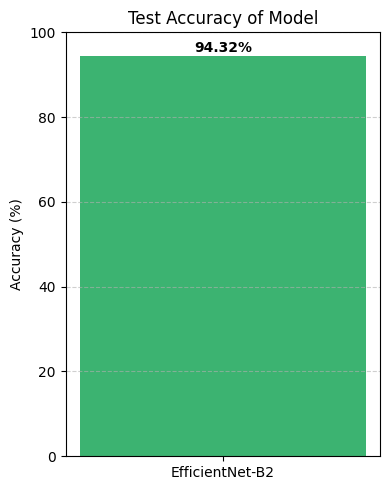

In [ ]:
import matplotlib.pyplot as plt

# Nilai akurasi tes
test_accuracy = 94.32  # sudah dalam persen

accuracy_values = [test_accuracy]
model_names = ['EfficientNet-B2']

plt.figure(figsize=(4, 5))  # Buat figure lebih sempit

# Atur lebar batang dengan 'width'
plt.bar(model_names, accuracy_values, color='mediumseagreen', width=0.4)
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy of Model')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Tambahkan nilai akurasi di atas batang
for i, v in enumerate(accuracy_values):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
import timm
print(model.classifier)



Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=1408, out_features=4, bias=True)
)


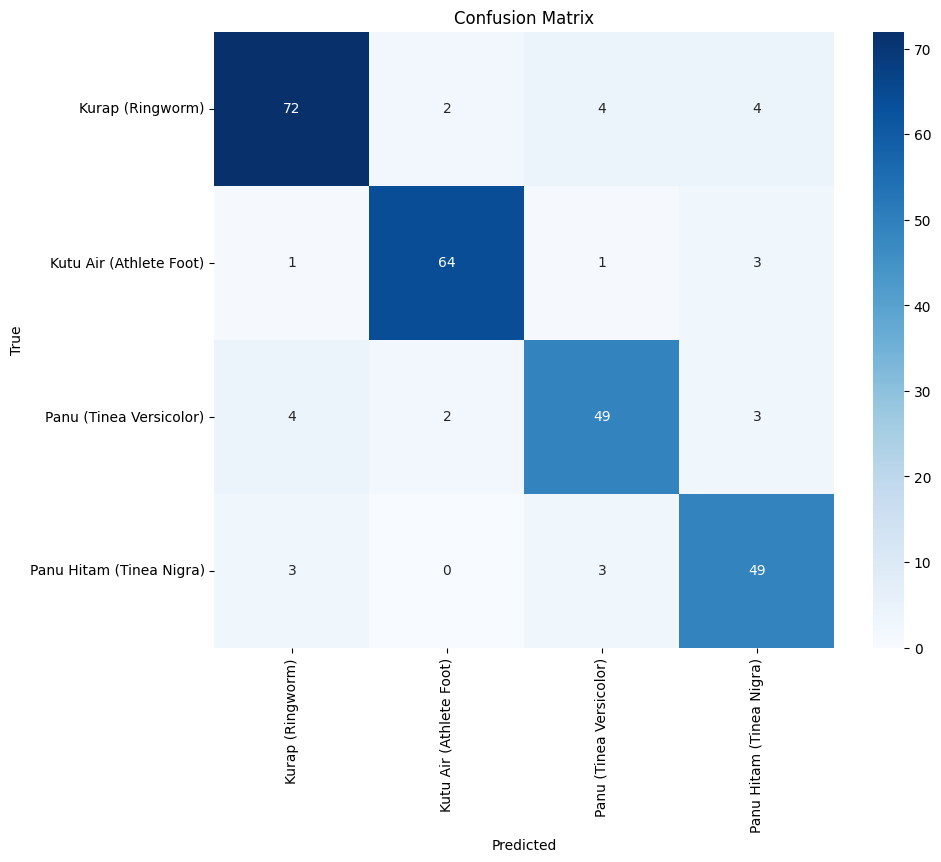


Classification Report:

                          precision    recall  f1-score   support

        Kurap (Ringworm)       0.90      0.88      0.89        82
 Kutu Air (Athlete Foot)       0.94      0.93      0.93        69
 Panu (Tinea Versicolor)       0.86      0.84      0.85        58
Panu Hitam (Tinea Nigra)       0.83      0.89      0.86        55

                accuracy                           0.89       264
               macro avg       0.88      0.89      0.88       264
            weighted avg       0.89      0.89      0.89       264



In [ ]:
import timm
model.eval()
y_true = []
y_pred = []

# Disable gradient calculation for inference
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=2))


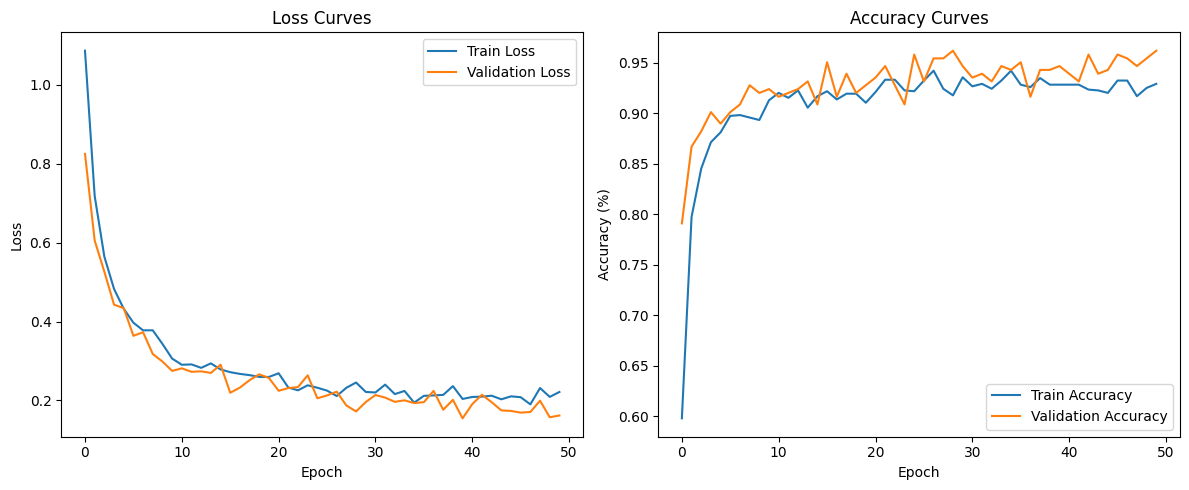

In [ ]:
import timm
import matplotlib.pyplot as plt
import torch

# Konversi semua elemen ke CPU dan float
train_loss_hist = [x.cpu().item() if torch.is_tensor(x) else x for x in train_loss_hist]
val_loss_hist = [x.cpu().item() if torch.is_tensor(x) else x for x in val_loss_hist]
train_acc_hist = [x.cpu().item() if torch.is_tensor(x) else x for x in train_acc_hist]
val_acc_hist = [x.cpu().item() if torch.is_tensor(x) else x for x in val_acc_hist]

# Plot
plt.figure(figsize=(12, 5))

# Subplot untuk loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Subplot untuk akurasi
plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
import random
import matplotlib.pyplot as plt
import torch

# Fungsi denormalisasi
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

# Menampilkan 8 prediksi acak dari test set
def predict_8_random_samples_from_test():
    model.eval()
    total_imgs = len(test_ds)

    if total_imgs < 8:
        print(f"Hanya ada {total_imgs} gambar di test_ds.")
        return

    indices = random.sample(range(total_imgs), 8)

    plt.figure(figsize=(8 * 3, 3))  # Ukuran gambar

    for i, idx in enumerate(indices):
        img, true_label = test_ds[idx]
        img_t = img.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img_t)
            _, pred = torch.max(outputs, 1)

        # Denormalisasi
        img_denorm = denormalize(img).permute(1, 2, 0).cpu().numpy().clip(0, 1)

        plt.subplot(1, 8, i + 1)
        plt.imshow(img_denorm)
        plt.title(f"Pred: {class_names[pred.item()]}\nTrue: {class_names[true_label]}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


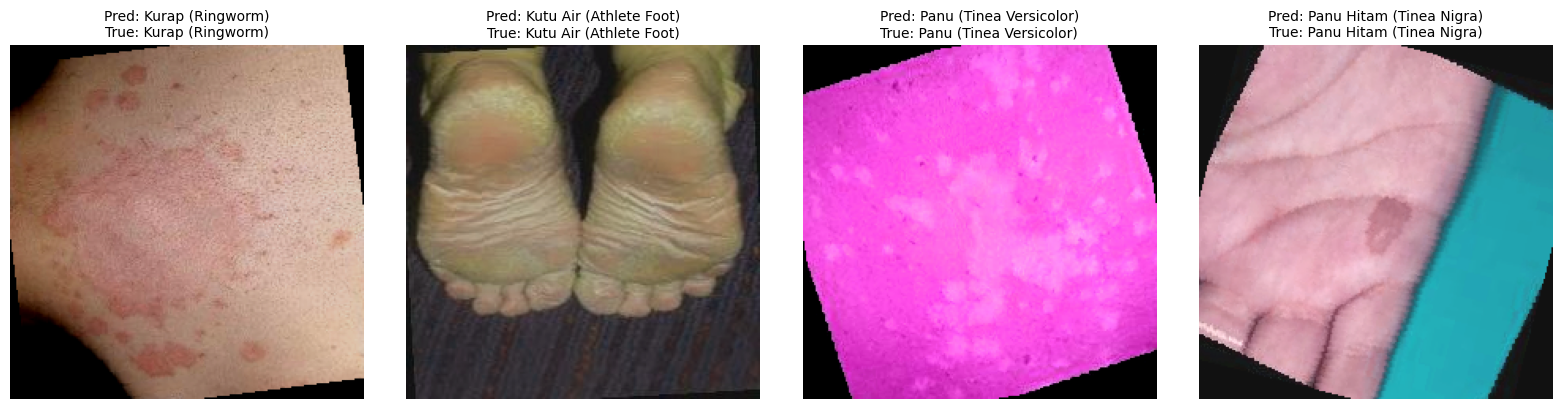

In [ ]:
predict_random_from_each_class_horizontal()
